# CEGE0004: Assignment 1

## Neural Network 

In this notebook, a multi-layer perceptron classifier is implemented in both pytorch and scikit-learn. That classifier is used to predict the default of credit card client.

## The Dataset

I am working with the default of credit card clients Data Set from UCI Machine Learning Repository, to to classify and predict customer defaults. The link of dataset is shown below:

https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

The dataset employes a binary variable, default (Yes = 1, No = 0), as the response variable. At the same time, the following 23 variables are used as explanatory variables:

X1: Amount of the given credit: it includes both the individual consumer credit and his/her family credit.

X2: Gender (1 = male; 2 = female).

X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).

X4: Marital status (1 = married; 2 = single; 3 = others).

X5: Age (year).

X6 - X11: History of past payment from April to September. (e.g. X6 = the repayment status in September; X7 = the repayment status in August; . . .) The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; . . .; 9 = payment delay for nine months and above.

X12 - X17: Amount of bill statement. (e.g. X12 = amount of bill statement in September; X13 = amount of bill statement in August; . . .).

X18 - X23: Amount of previous payment. (e.g. X18 = amount paid in September; X19 = amount paid in August, 2005; . . .).

### Read the pretreated dataset

In [1]:
import pandas as pd

# read the dataset into a Pandas DataFrame
xs_train = pd.read_csv("x_train.csv")
xs_test = pd.read_csv("x_test.csv")

ys_train = pd.read_csv("y_train.csv")
ys_train = ys_train['default payment next month']
ys_test = pd.read_csv("y_test.csv")
ys_test = ys_test['default payment next month']

# print the shape of the training set
print('training set shape:\t', xs_train.shape)
# print the shape of the test set
print('test set shape:\t\t', xs_test.shape)

training set shape:	 (24000, 23)
test set shape:		 (6000, 23)


## Preparation for the model based on pytorch

Here a multi-layer perceptron neural network is established with pytorch environment. Some codes are referenced from: https://github.com/aldolipani/CEGE0004/blob/master/5%20-%20Week/neural_networks.ipynb

### Importing the required package

In [2]:
import multiprocessing
import torch 
import torch.nn as nn 
import numpy as np 
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import ParameterGrid

### Define data handling function

The BinaryDataset class is designed to handle input features and binary target labels.
It converts the input data (xs) into a float tensor and target labels (ys) into a long tensor.

In [3]:
class binarydataset(Dataset):
    '''
    A custom dataset class for binary classification tasks that extends the PyTorch Dataset class.

    Args:
        X (pd.DataFrame): The input features in a pandas DataFrame.
        y (pd.DataFrame): The binary target labels in a pandas DataFrame.
    
    The BinaryDataset class is designed to handle input features and binary target labels.
    It converts the input data (X) into a float tensor and target labels (y) into a long tensor.
    '''
    def __init__(self, X, y):
        # convert X to a float tensor and store it in self.X
        self.X = torch.tensor(X.values.astype(np.float32), dtype=torch.float32)
        # convert y to a long tensor and store it in self.y
        self.y = torch.tensor(y.values.astype(np.float32), dtype=torch.long)

    def __len__(self):
        # return the length of the input tensor
        return len(self.X)

    def __getitem__(self, idx):
        # return the X and y tensors at the given index
        return self.X[idx], self.y[idx]


### Define the multi-layer perceptron neural network

The MLP class consists of an input layer, one or more hidden layers, and an output layer. It uses the ReLU activation function for the hidden layers.

In [4]:
class MLP(nn.Module):
    '''
    A custom Multilayer Perceptron (MLP) class that extends the PyTorch nn.Module class.

    Args:
        input_size (int): The number of neurons in the input layer, which depends on the dataset.
        hidden_sizes (list): A list of integers representing the number of neurons in each hidden layer.
        output_size (int): The number of neurons in the output layer.

    The MLP class consists of an input layer, one or more hidden layers, and an output layer.
    It uses the ReLU activation function for the hidden layers.
    '''
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList() # list of layers
        next_hidden_size = input_size # input size of the first layer, this depends on the dataset
        for hidden_size in hidden_sizes: # for loop to define the next hidden layers
            self.layers.append(nn.Linear(next_hidden_size, hidden_size))
            next_hidden_size = hidden_size
        self.output = nn.Linear(next_hidden_size, output_size) # output layer

    def forward(self, x): 
        '''
        Defines the forward pass for the MLP model.

        Args:
            x (torch.Tensor): The input tensor.

        Returns:
            out (torch.Tensor): The output tensor after passing through the MLP layers and activation functions.
        '''
        out = x
        for layer in self.layers:
            out = layer(out)
            out = nn.functional.relu(out) # activation function
        out = self.output(out)
        return out

### Define the loss computing function

This function computes the loss on a given test set using a trained model and a loss criterion.

In [5]:
def compute_loss_test(model, test_loader, criterium):
    '''
    This function computes the loss on a given test set using a trained model and a loss criterion.

    Args:
        model (nn.Module): The trained model to use for prediction.
        test_loader (DataLoader): The DataLoader containing the test set.
        criterium (nn.Module): The loss criterion to use.

    Returns:
        float: The average loss over the test set.
    '''
    tot_loss = 0
    batch_size = test_loader.batch_size
    for i, batch in enumerate(test_loader):
        # Extract input and output data from the batch.
        xs, ys = batch
        # Move the data to the device (GPU).
        xs, ys = xs.to(device), ys.to(device)
        # generate the predictions using the model
        pred_ys = model(xs)
        # evaluate the predictions using the loss criterion
        loss = criterium(pred_ys, ys)
        # get the loss value and sum it to the total loss
        tot_loss += loss.item()
        if (i + 1) % batch_size == 0:
            break
    # normalize the loss based on the number of testing examples
    loss = tot_loss / batch_size
    return loss

### Define the accuracy computing function

This function computes the accuracy of a given data set using a trained model.

In [6]:
def accuracy(data_loader):
    '''
    This function computes the accuracy of a given data set using a trained model.

    Args:
        data_loader (DataLoader): The DataLoader containing the data set.

    Returns:
        float: The accuracy of the model on the given data set.
    '''
    # here we count the correct answers
    correct = 0.0
    # here we count all the answers
    total = 0.0
    # ignore the gradient graph
    with torch.no_grad():
        for batch in data_loader:
            # Extract input and output data from the batch.
            xs, ys = batch
            # Move the data to the device (GPU).
            hat_ys = model(xs.to(device)).detach().cpu()
            # get the predicted classes
            _, hat_ys = torch.max(hat_ys, 1)
            # increment the correct count if prediction matches the ground truth
            correct += (hat_ys == ys).sum()
            # increment the total count by the number of examples in the batch
            total += ys.size(0)

    # return the accuracy as the ratio of correct to total counts
    return correct / total


### Define the model training function

This function initializes the MLP model with the given hyperparameters, creates an optimizer and a loss function, and then trains the model using the input data. The training process is performed for a fixed number of epochs.

During training, the function records the training and testing losses every 200 batches and prints the current progress. After training is complete, the function returns the trained model, DataLoader instances for the training and testing sets, and the lists of training and testing losses.

In [7]:
def train_model(params):
    '''
    Trains an MLP model with the given hyperparameters and data.

    Args:
        params (dict): A dictionary containing the following keys:
            - 'hidden_sizes' (list): A list of integers representing the number of neurons in each hidden layer.
            - 'lr' (float): The learning rate for the optimizer.
            - 'weight_decay' (float): The weight decay (L2 penalty) for the optimizer.

    Returns:
        model (nn.Module): The trained MLP model.
        train_loader (DataLoader): DataLoader instance for the training set.
        test_loader (DataLoader): DataLoader instance for the testing set.
        training_loss (list): A list of training losses recorded every 200 batches.
        testing_loss (list): A list of testing losses recorded every 200 batches.

    This function initializes the MLP model with the given hyperparameters, creates an optimizer and a loss function,
    and then trains the model using the input data. The training process is performed for a fixed number of epochs.
    During training, the function records the training and testing losses every 200 batches and prints the current
    progress. After training is complete, the function returns the trained model, DataLoader instances for the
    training and testing sets, and the lists of training and testing losses.
    '''
    # initialize the model with the current set of hyperparameters
    model = MLP(23, params['hidden_sizes'], 2)

    # move the model to the device (GPU)
    model.to(device)
    # set optimizer and criterium
    optimizer = torch.optim.SGD(model.parameters(),
                                lr=params['lr'],
                                momentum=0.99,
                                weight_decay=params['weight_decay'])
    criterium = nn.CrossEntropyLoss()

    # set the batch size for training
    batch_size = 20
    # use the DataLoader helper to generate an iterator for the train set to return random examples 5 by 5
    train_loader = DataLoader(traindata, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
    # use the DataLoader helper to generate an iterator for the test set to return examples 100 by 100
    test_loader = DataLoader(testdata, batch_size=100, shuffle=False, num_workers=0, pin_memory=True)

    # set the number of epochs for training
    epochs = 5
    # set the model to training mode
    model.train()

    # These variables are used to store the losses.
    running_loss = 0
    training_loss = []
    testing_loss = []
    print(f'Testing model for parameters {params}!')
    # train the model for a fixed number of epochs
    for epoch in range(epochs):
        # Loop over the batches.
        for i, batch in enumerate(train_loader):

            # Extract input and output data from the batch.
            xs, ys = batch
            # Move the data to the device (GPU).
            xs, ys = xs.to(device), ys.to(device)
            # Reset the gradients.
            optimizer.zero_grad()
            # Generate the predictions.
            pred_ys = model(xs)
            # Compute the loss.
            loss = criterium(pred_ys, ys)
            # Backpropagation.
            loss.backward()
            # Gradient clipping.
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
            # Update the model parameters.
            optimizer.step()

            # Update the running loss.
            running_loss += loss.item()
            # Every 200 batches, print statistics about the training.
            if (i + 1) % 200 == 0:
                # Compute the average training loss on the last 200 batches.
                running_loss /= 200
                # Keep track of the training loss.
                training_loss.append(running_loss)
                # Set the model to evaluation mode.
                model.eval()
                # Compute the validation loss.
                test_loss = compute_loss_test(model, test_loader, criterium)
                # Keep track of the validation loss.
                testing_loss.append(test_loss)
                # Set the model back to training mode.
                model.train()
                # Print the training and validation losses.
                print('Epoch [%d/%d], Step [%d/%d], Train Loss: %.4f, Test Loss: %.4f' % (
                    epoch + 1,
                    epochs,
                    i + 1,
                    len(xs_train) // batch_size,
                    running_loss,
                    test_loss))
                # Reset the running loss.
                running_loss = 0
                
    return model, train_loader, test_loader, training_loss, testing_loss

### Set dataset and device

In [8]:
# allows for multiprocessing on Windows
multiprocessing.freeze_support()

# create a training dataset object
traindata = binarydataset(xs_train, ys_train)
# create a test dataset object
testdata = binarydataset(xs_test, ys_test)

# check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Train the model with random hyper parameters

In [9]:
# train the model with hyper parameters
params = {'hidden_sizes': (15, 15, 2), 'lr': 0.00001, 'weight_decay': 0.0001}
model, train_loader, test_loader, training_loss, testing_loss = train_model(params)

Testing model for parameters {'hidden_sizes': (15, 15, 2), 'lr': 1e-05, 'weight_decay': 0.0001}!
Epoch [1/5], Step [200/1200], Train Loss: 273.8235, Test Loss: 106.3747
Epoch [1/5], Step [400/1200], Train Loss: 102.3678, Test Loss: 47.4283
Epoch [1/5], Step [600/1200], Train Loss: 62.7847, Test Loss: 35.1630
Epoch [1/5], Step [800/1200], Train Loss: 55.1259, Test Loss: 24.8968
Epoch [1/5], Step [1000/1200], Train Loss: 36.6609, Test Loss: 12.0003
Epoch [1/5], Step [1200/1200], Train Loss: 14.8619, Test Loss: 4.8194
Epoch [2/5], Step [200/1200], Train Loss: 9.9600, Test Loss: 2.5969
Epoch [2/5], Step [400/1200], Train Loss: 2.8739, Test Loss: 1.7749
Epoch [2/5], Step [600/1200], Train Loss: 3.1038, Test Loss: 1.4540
Epoch [2/5], Step [800/1200], Train Loss: 2.7915, Test Loss: 1.1266
Epoch [2/5], Step [1000/1200], Train Loss: 3.8360, Test Loss: 0.9427
Epoch [2/5], Step [1200/1200], Train Loss: 1.6322, Test Loss: 0.8278
Epoch [3/5], Step [200/1200], Train Loss: 1.1787, Test Loss: 0.7829
E

### Compute the accuracy

In [10]:
# Set the model to evaluation mode.
model.eval()
# Compute the training accuracy.
train_accuracy = accuracy(train_loader)
print('Train accuracy of the MLP: {:.3f}'.format(train_accuracy))
# Compute the testing accuracy.
test_accuracy = accuracy(test_loader)
print('Test accuracy of the MLP: {:.3f}'.format(test_accuracy))
# Name the accuracy for plotting
accuracy1 = test_accuracy.item()

Train accuracy of the MLP: 0.777
Test accuracy of the MLP: 0.784


The accuracy is low, because the hyper parameters applied may not be the best option. In the following part, hyper parameters are tuned to determine the best groups, in order to increase the accuracy.

## Determine best hyper parameter

### Define the hyper parameters to tune

The number of hidden neurons should be 2/3 the size of the input layer, plus the size of the output layer. (Reference from: 
https://stackoverflow.com/questions/15550606/neural-networks-input-and-output-layers.)
Learning rate and weight decay were picked after rough trials.

In [11]:
# define the hyperparameters to tune
param_grid = {'hidden_sizes': [(15, 15, 2), (20, 20, 2), (25, 25, 2)],
                        'lr': [0.001, 0.0001, 0.00001],
              'weight_decay': [0.01, 0.0001, 0.00001]}

# create a list of all possible combinations of hyperparameters
param_list = list(ParameterGrid(param_grid))

### Hyper parameters tuning

The computation here was massive, thus the model was operated by GPU to speed up.

In [12]:
# set initial best_accuracy to 0
best_accuracy = 0
# loop over all combinations of hyperparameters
for params in param_list:
    model, train_loader, test_loader, training_loss, testing_loss = train_model(params)
    # evaluate the model on the validation set
    model.eval()
    # Compute the training accuracy.
    train_accuracy = accuracy(train_loader)
    # update the best set of hyperparameters based on the validation accuracy
    if train_accuracy > best_accuracy:
        best_accuracy = train_accuracy
        best_params = params
        print(f'Best parameter is updated to {best_params}')

    print('-' * 100)

Testing model for parameters {'hidden_sizes': (15, 15, 2), 'lr': 0.001, 'weight_decay': 0.01}!
Epoch [1/5], Step [200/1200], Train Loss: 58.8546, Test Loss: 0.3133
Epoch [1/5], Step [400/1200], Train Loss: 0.5462, Test Loss: 0.3169
Epoch [1/5], Step [600/1200], Train Loss: 0.5228, Test Loss: 0.3133
Epoch [1/5], Step [800/1200], Train Loss: 0.5264, Test Loss: 0.3142
Epoch [1/5], Step [1000/1200], Train Loss: 0.5252, Test Loss: 0.3134
Epoch [1/5], Step [1200/1200], Train Loss: 0.5202, Test Loss: 0.3133
Epoch [2/5], Step [200/1200], Train Loss: 0.5287, Test Loss: 0.3133
Epoch [2/5], Step [400/1200], Train Loss: 0.5354, Test Loss: 0.3139
Epoch [2/5], Step [600/1200], Train Loss: 0.5409, Test Loss: 0.3134
Epoch [2/5], Step [800/1200], Train Loss: 0.5324, Test Loss: 0.3137
Epoch [2/5], Step [1000/1200], Train Loss: 0.5201, Test Loss: 0.3134
Epoch [2/5], Step [1200/1200], Train Loss: 0.5245, Test Loss: 0.3133
Epoch [3/5], Step [200/1200], Train Loss: 0.5285, Test Loss: 0.3135
Epoch [3/5], Ste

## Train the model with best hyper parameters

In [13]:
# train the model with best hyperparameters
params = best_params
model, train_loader, test_loader, training_loss, testing_loss = train_model(params)


Testing model for parameters {'hidden_sizes': (25, 25, 2), 'lr': 1e-05, 'weight_decay': 0.0001}!
Epoch [1/5], Step [200/1200], Train Loss: 11.1519, Test Loss: 1.9392
Epoch [1/5], Step [400/1200], Train Loss: 1.1711, Test Loss: 0.5006
Epoch [1/5], Step [600/1200], Train Loss: 0.7530, Test Loss: 0.4268
Epoch [1/5], Step [800/1200], Train Loss: 0.6584, Test Loss: 0.4150
Epoch [1/5], Step [1000/1200], Train Loss: 0.6751, Test Loss: 0.4136
Epoch [1/5], Step [1200/1200], Train Loss: 0.8123, Test Loss: 0.4054
Epoch [2/5], Step [200/1200], Train Loss: 0.6526, Test Loss: 0.4031
Epoch [2/5], Step [400/1200], Train Loss: 0.5966, Test Loss: 0.4045
Epoch [2/5], Step [600/1200], Train Loss: 0.7557, Test Loss: 0.4020
Epoch [2/5], Step [800/1200], Train Loss: 0.6308, Test Loss: 0.4086
Epoch [2/5], Step [1000/1200], Train Loss: 0.6027, Test Loss: 0.4125
Epoch [2/5], Step [1200/1200], Train Loss: 0.7569, Test Loss: 0.4035
Epoch [3/5], Step [200/1200], Train Loss: 0.5798, Test Loss: 0.4024
Epoch [3/5], S

## Plot training loss and testing loss

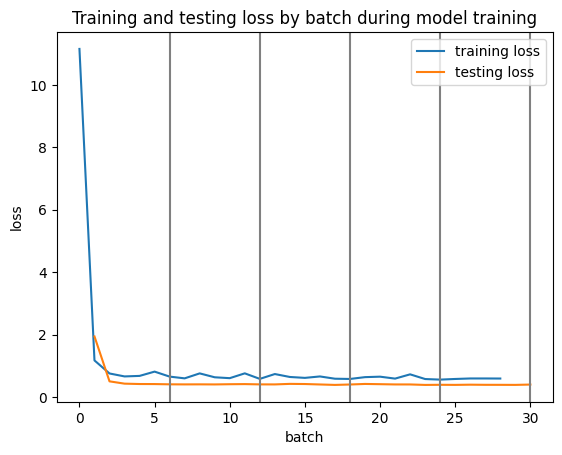

In [14]:
import matplotlib.pyplot as plt

# Remove the last training loss value (it might be incomplete).
training_loss.pop()
# Insert a NaN value at the beginning of the testing loss list (to shift the plot).
testing_loss.insert(0, float('NaN'))

# Plot the training and testing losses.
plt.plot(training_loss, label="training loss")
plt.plot(testing_loss, label="testing loss")
plt.legend(loc='upper right')

# Add vertical lines to show the end of each epoch.
epochs = 5
batch_size = 20
for i in range(epochs):
    plt.axvline(x=(len(xs_train) // batch_size) * (i + 1) / 200, color='gray')
plt.title('Training and testing loss by batch during model training')
plt.ylabel('loss')
plt.xlabel('batch')
plt.show()

As shown in the figure above, the training loss and the testing loss quickly converges,then remains almost consistent. Thus, the training is successful.

## Compute the train accuracy and test accuracy

In [15]:
# Set the model to evaluation mode.
model.eval()
# Compute the training accuracy.
train_accuracy = accuracy(train_loader)
print('Train accuracy of the MLP: {:.3f}'.format(train_accuracy))
# Compute the testing accuracy.
test_accuracy = accuracy(test_loader)
print('Test accuracy of the MLP: {:.3f}'.format(test_accuracy))
# Name the accuracy for plotting
accuracy2 = test_accuracy.item()

Train accuracy of the MLP: 0.778
Test accuracy of the MLP: 0.784


The accuracy increase here is not considerable, which is possiblly resulted by the properties of dataset itself. Besides, activation function, optimizer and criterium may not be the most suitable one in that model. In the following part, the model in scikit-learn package is adopted, which provides more flexibity of hyper parameter tuning.

## Use scikit-learn package to train the model

There is a mature MLP classifier model in scikit-learn library, which allow us to further tune the hyper parameter (even activation function and optimizer). (Reference from https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)

In [16]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# Standardize the input features
scaler = StandardScaler()
xs_train = scaler.fit_transform(xs_train)
xs_test = scaler.transform(xs_test)

# Define the MLPClassifier
mlp_classifier = MLPClassifier(random_state=42)

# Set up hyperparameters for GridSearchCV
param_grid = {
    'hidden_layer_sizes': [(15,15), (20, 20), (25, 25)], # Different hidden layer configurations
    'activation': ['relu', 'tanh'], # Activation functions
    'solver': ['adam', 'sgd'], # Optimizers
    'learning_rate_init': [0.00001, 0.0001, 0.001], # Initial learning rates
}

# Define the GridSearchCV object
grid_search = GridSearchCV(mlp_classifier, param_grid, scoring='accuracy', cv=5, n_jobs=-1)

# Train the MLPClassifier using GridSearchCV on the training data
grid_search.fit(xs_train, ys_train)

# Print the best hyperparameters
print("Best hyperparameters found by GridSearchCV:")
print(grid_search.best_params_)

# Make predictions on the testing data using the best estimator
ys_pred = grid_search.best_estimator_.predict(xs_test)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(ys_test, ys_pred)
print(f"Accuracy: {accuracy:.2f}")
# Name the accuracy for plotting
accuracy3 = accuracy

Best hyperparameters found by GridSearchCV:
{'activation': 'tanh', 'hidden_layer_sizes': (20, 20), 'learning_rate_init': 0.0001, 'solver': 'adam'}
Accuracy: 0.83


Fortunately, there is no best hyperparameters on the boundary. And the accuracy rate has improved significantly!

## Plot the accuracy throughout the model improvement

This plot can intuitively show the accuracy improvement throughout trials

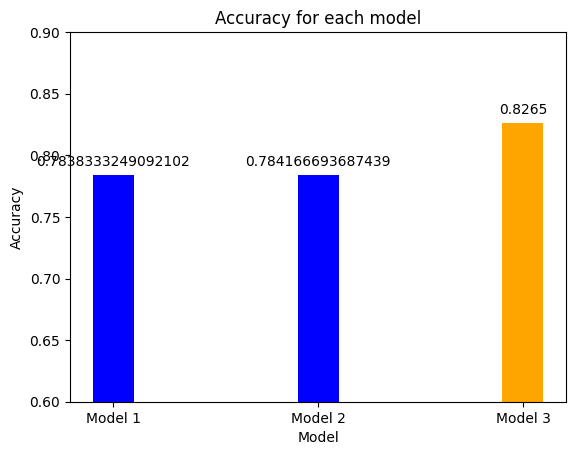

In [17]:
import matplotlib.pyplot as plt

# Define dataset to plot
x_axis = ['Model 1', 'Model 2', 'Model 3']
y_axis = [accuracy1, accuracy2, accuracy3]

bar_width = 0.2

# Find the index of the highest value
highest_value_index = y_axis.index(max(y_axis))

# Create a color list and set a different color for the highest value
colors = ['blue'] * len(x_axis)
colors[highest_value_index] = 'orange'
plt.ylim(0.6,0.9)
# Create a bar chart
plt.bar(x_axis, y_axis, width=bar_width, color=colors)

# Display the value above each bar
for i, value in enumerate(y_axis):
    plt.text(i, value+0.005, str(value), ha='center', va='bottom')
             
# Add title and labels for the axes
plt.title('Accuracy for each model')
plt.xlabel('Model')
plt.ylabel('Accuracy')

# Show the plot
plt.show()

## Save the trained model to pickle file

Save the best MLP model for future use (Referenced from: https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/)

In [18]:
import pickle

# Save the best model to a file
with open("MLP_sklearn.sav", "wb") as f:
    pickle.dump(grid_search.best_estimator_, f)
    
'''
# Load the best model from the file
with open("MLP_sklearn.sav", "rb") as f:
    loaded_model = pickle.load(f)

# Use the loaded model for prediction
ys_pred = loaded_model.predict(xs_test)
'''

'\n# Load the best model from the file\nwith open("MLP_sklearn.sav", "rb") as f:\n    loaded_model = pickle.load(f)\n\n# Use the loaded model for prediction\nys_pred = loaded_model.predict(xs_test)\n'